In [ ]:
import torch
import torch.nn as nn
import torchvision

# CIFAR10

In [ ]:
from torchvision import transforms
from functools import partial

def compress_img(img, k):
    U, D, V = torch.linalg.svd(img, full_matrices=False)
    compressed_img = torch.matmul(U[..., :k], torch.diag_embed(D[..., :k]))
    compressed_img = torch.matmul(compressed_img, V[..., :k, :])
    return compressed_img

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

linear_grayscale_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Grayscale(num_output_channels=1),
     transforms.Normalize((0.5), (0.5)),
     transforms.Lambda(lambda x: torch.flatten(x, start_dim=1))])

cnn_grayscale_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Grayscale(num_output_channels=1),
     transforms.Normalize((0.5), (0.5))])

batch_size = 25

trainset = torchvision.datasets.CIFAR10(root='.', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='.', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=8),
            # nn.LeakyReLU(),
            # nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=1, padding=0),
            # nn.ReLU(),
        )

        self.decoder = nn.Sequential(
        #     nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=1, stride=1, padding=0),
        #     nn.LeakyReLU(),
        #     nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=8, stride=2, padding=0),
        #     nn.LeakyReLU(),
            # nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=8, stride=1, padding=0),
            # nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, padding=0),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=2, stride=2, padding=0),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=5, stride=1, padding=2),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
epochs = 2
import torch.optim as optim
from tqdm.notebook import tqdm

criterion = nn.L1Loss()
net = AutoEncoder().cuda()
optimizer = optim.Adam(net.parameters(), lr=0.0001, amsgrad=True)


for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 0:    # print every 2000 mini-batches
            tqdm.write(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item():.3f}')
            running_loss = 0.0

print('Finished Training')

0it [00:00, ?it/s]

[1,     1] loss: 0.428
[1,   201] loss: 0.373
[1,   401] loss: 0.292
[1,   601] loss: 0.350
[1,   801] loss: 0.338
[1,  1001] loss: 0.312
[1,  1201] loss: 0.291
[1,  1401] loss: 0.314
[1,  1601] loss: 0.304
[1,  1801] loss: 0.284


0it [00:00, ?it/s]

[2,     1] loss: 0.263
[2,   201] loss: 0.286
[2,   401] loss: 0.285
[2,   601] loss: 0.268
[2,   801] loss: 0.300
[2,  1001] loss: 0.310
[2,  1201] loss: 0.271
[2,  1401] loss: 0.306
[2,  1601] loss: 0.290
[2,  1801] loss: 0.288
Finished Training


In [ ]:
testiter = iter(testloader)
images, labels = next(testiter)
images.shape

torch.Size([25, 3, 32, 32])

In [ ]:
net.eval()
outputs = net(images.cuda())
outputs.shape

torch.Size([25, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Decoded')

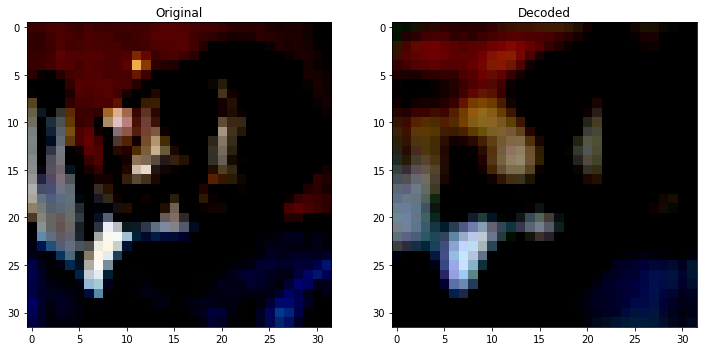

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(np.transpose(images.detach()[0].numpy(), (1, 2, 0)))
ax[1].imshow(np.transpose(outputs.cpu().detach()[0].numpy(), (1, 2, 0)))
ax[0].set_title("Original")
ax[1].set_title("Decoded")

In [ ]:
net.encoder(images[0].unsqueeze(dim=0).cuda()).shape

torch.Size([1, 64, 8, 8])

# VAE
https://theaisummer.com/Autoencoder/

## MNIST

In [ ]:
from torch.nn import functional as F

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= batch_size * 784

    return BCE + KLD

In [ ]:
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()

        # ENCODER
        self.fc1 = nn.Linear(784, 400)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(400, 20)  # mu layer
        self.fc22 = nn.Linear(400, 20)  # logvariance layer

        # DECODER
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def reparameterize(self, mu, logvar):

        #mu :  mean matrix
        #logvar :  variance matrix
        if self.training:
            std = logvar.mul(0.5).exp_()  # type: Variable
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

In [ ]:
from torchvision import transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5),
    #  transforms.Grayscale(),
     transforms.Lambda(lambda x: x.flatten())])

batch_size = 25

trainset = torchvision.datasets.MNIST(root='.', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='.', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
from tqdm.notebook import tqdm

model = LinearVAE().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in tqdm(enumerate(trainloader), leave=False):
        data = data.cuda()
        # print(data.shape)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()


def test(epoch):
    model.eval()
    test_loss = 0

    for i, (data, _) in enumerate(testloader):
        data = data.cuda()
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()

for epoch in tqdm(range(1, 5 + 1)):
    train(epoch)
    test(epoch)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
testiter = iter(testloader)
images, labels = next(testiter)
images.shape

torch.Size([25, 784])

In [ ]:
mu, logvar = model.encode(images.cuda())
z = model.reparameterize(mu, logvar)
# print(encoded.shape)
decoded = model.decode(z)
print(decoded.shape)

torch.Size([25, 784])


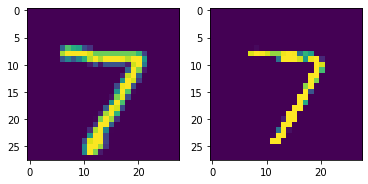

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[0].cpu().detach().numpy().reshape(28, 28))
ax[1].imshow(decoded[0].cpu().detach().numpy().reshape(28, 28))

## CIFAR10

In [ ]:
class CIFARLinearVAE(nn.Module):
    def __init__(self):
        super(CIFARLinearVAE, self).__init__()

        # ENCODER
        self.fc1 = nn.Linear(1024, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc31 = nn.Linear(256, 128)  # mu layer
        self.fc32 = nn.Linear(256, 128)  # logvariance layer

        # DECODER
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 1024)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.fc31(h2), self.fc32(h2)

    def decode(self, z):
        h3 = self.relu(self.fc4(z))
        h4 = self.relu(self.fc5(h3))
        return self.sigmoid(self.fc6(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 1024))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def reparameterize(self, mu, logvar):

        #mu :  mean matrix
        #logvar :  variance matrix
        if self.training:
            std = logvar.mul(0.5).exp_()  # type: Variable
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 1024))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= batch_size * 1024

    return BCE + KLD

In [ ]:
from torchvision import transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5),
     transforms.Grayscale(),
     transforms.Lambda(lambda x: x.flatten())])

batch_size = 25

trainset = torchvision.datasets.CIFAR10(root='.', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='.', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from tqdm.notebook import tqdm

model = CIFARLinearVAE().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in tqdm(enumerate(trainloader), leave=False):
        data = data.cuda()
        # print(data.shape)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()


def test(epoch):
    model.eval()
    test_loss = 0

    for i, (data, _) in enumerate(testloader):
        data = data.cuda()
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()

for epoch in tqdm(range(1, 5 + 1)):
    train(epoch)
    test(epoch)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
testiter = iter(testloader)
images, labels = next(testiter)
images.shape

torch.Size([25, 1024])

In [ ]:
mu, logvar = model.encode(images.cuda())
z = model.reparameterize(mu, logvar)
# print(encoded.shape)
decoded = model.decode(z)
print(decoded.shape)

torch.Size([25, 1024])


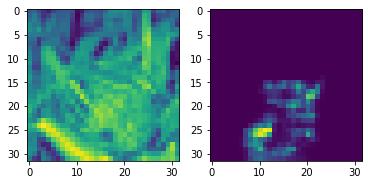

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[4].cpu().detach().numpy().reshape(32, 32))
ax[1].imshow(decoded[4].cpu().detach().numpy().reshape(32, 32))

## Try 2

In [ ]:
from torchvision import transforms
from torch.nn import functional as F

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

batch_size = 25

trainset = torchvision.datasets.CIFAR10(root='.', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='.', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class CVAE(nn.Module):
    def __init__(self,
                 in_channels=3,
                 latent_dim=256,
                 hidden_dims=None,
                 **kwargs):
        super(CVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512*4]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=1,
                                               padding=1,
                                               output_padding=0),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # print(result.shape)
        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 2048, 2, 2)
        result = self.decoder(result)
        # print(result.shape)
        result = self.final_layer(result)
        # print(result.shape)
        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = 0.00025 # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs):
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x, **kwargs):
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x
 W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]



In [ ]:
model

CVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequenti

In [ ]:
from tqdm.notebook import tqdm

model = CVAE().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in tqdm(enumerate(trainloader), leave=False):
        data = data.cuda()
        # print(data.shape)
        optimizer.zero_grad()
        recon_batch, _, mu, logvar = model(data)
        loss = model.loss_function(recon_batch, data, mu, logvar)['loss']
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    return train_loss


def test(epoch):
    model.eval()
    test_loss = 0

    for i, (data, _) in enumerate(testloader):
        data = data.cuda()
        recon_batch, z, mu, logvar = model(data)
        test_loss += model.loss_function(recon_batch, data, mu, logvar, z)['loss'].item()
    return test_loss

for epoch in tqdm(range(25)):
    train_loss = train(epoch)
    test_loss = test(epoch)
    print(f"{epoch}: Train loss: {train_loss}, Test loss: {test_loss}")

  0%|          | 0/25 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3fd8b93c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3fd8b93c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

0: Train loss: 225.33500833809376, Test loss: 33.687683932483196


0it [00:00, ?it/s]

1: Train loss: 172.57917974889278, Test loss: 31.201428689062595


0it [00:00, ?it/s]

2: Train loss: 161.58587453514338, Test loss: 29.301174610853195


0it [00:00, ?it/s]

3: Train loss: 153.663802459836, Test loss: 27.86922712624073


0it [00:00, ?it/s]

4: Train loss: 148.19513008370996, Test loss: 26.84561152011156


0it [00:00, ?it/s]

5: Train loss: 144.61918929591775, Test loss: 26.608348090201616


0it [00:00, ?it/s]

6: Train loss: 142.22048161923885, Test loss: 26.41284165158868


0it [00:00, ?it/s]

7: Train loss: 139.98313692957163, Test loss: 25.972579635679722


0it [00:00, ?it/s]

8: Train loss: 137.97207479923964, Test loss: 25.68559043481946


0it [00:00, ?it/s]

9: Train loss: 136.52904583886266, Test loss: 25.368567641824484


0it [00:00, ?it/s]

10: Train loss: 135.2633748166263, Test loss: 25.553892597556114


0it [00:00, ?it/s]

11: Train loss: 133.83946095779538, Test loss: 25.05162961781025


0it [00:00, ?it/s]

12: Train loss: 132.86816639825702, Test loss: 25.00681285560131


0it [00:00, ?it/s]

13: Train loss: 131.64054615423083, Test loss: 24.864816058427095


0it [00:00, ?it/s]

14: Train loss: 130.7193068191409, Test loss: 24.664569657295942


0it [00:00, ?it/s]

15: Train loss: 129.98363046720624, Test loss: 24.39261917024851


0it [00:00, ?it/s]

16: Train loss: 129.25129280239344, Test loss: 24.455120261758566


0it [00:00, ?it/s]

17: Train loss: 128.5788800008595, Test loss: 24.305530842393637


0it [00:00, ?it/s]

18: Train loss: 127.95797057077289, Test loss: 24.342442765831947


0it [00:00, ?it/s]

19: Train loss: 127.35439680889249, Test loss: 24.166724760085344


0it [00:00, ?it/s]

20: Train loss: 126.69461650028825, Test loss: 24.24742767214775


0it [00:00, ?it/s]

21: Train loss: 126.4329385459423, Test loss: 24.006268493831158


0it [00:00, ?it/s]

22: Train loss: 125.76568837463856, Test loss: 23.980322297662497


0it [00:00, ?it/s]

23: Train loss: 125.3251419365406, Test loss: 23.80311430990696


0it [00:00, ?it/s]

24: Train loss: 124.99259193241596, Test loss: 23.933383222669363


In [ ]:
testiter = iter(testloader)
images, labels = next(testiter)
recon_img, _, _, _ = model(images.cuda())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed')

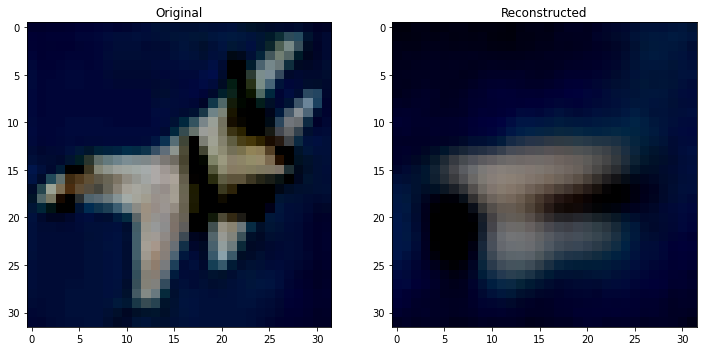

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(images[10].permute(1, 2, 0).detach().cpu())
ax[0].grid(False)
ax[0].set_title("Original")
ax[1].imshow(recon_img[10].permute(1, 2, 0).detach().cpu())
ax[1].grid(False)
ax[1].set_title("Reconstructed")

In [ ]:
all_labels = []
all_embeddings = []
for batch_idx, (data, labels) in tqdm(enumerate(testloader)):
    data = data.cuda()
    mu, sigma = model.encode(data)
    emb = model.reparameterize(mu, sigma)
    all_labels.extend(labels)
    all_embeddings.append(emb)

all_embeddings = torch.vstack(all_embeddings)
all_embeddings.shape

0it [00:00, ?it/s]

torch.Size([10000, 128])

In [ ]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import homogeneity_score, adjusted_mutual_info_score, adjusted_rand_score

kmeans = KMeans(n_clusters=10)
estimator = make_pipeline(StandardScaler(), kmeans).fit(all_embeddings.detach().cpu().numpy())
homogeneity_score(all_labels, estimator[-1].labels_)

0.03198704514865731

In [ ]:
adjusted_mutual_info_score(all_labels, estimator[-1].labels_)

0.030313500875356687